# Goal 
- Run a separate regression for each analysis feature to see whether any have an effect on classification accuracy. 
- Plot in the same style as the multivariate regression. 
- Still use mixed effects. 
- Don't look at region because there are other analyses dealing with that. 

**ToDO- it might be nice to look at each distribution again and report any that have odd effects**

In [4]:
options(jupyter.plot_mimetypes = "image/png")
library(nlme)
library(ggplot2)
library(corrplot)
library(gridExtra)
library(grid)
library(data.table)
library(effects)
library(xtable)
library(extrafont)
library(lsmeans)
library(multcomp)


## Load Data

In [5]:
data = read.csv("../data_meta_analysis/Data_Classifications_v7.csv")

data<-data[c('PID','Info.type','Accuracy.50','Significance','Roi.Search',
             'Pattern.type','Classifier.type','Scanner','Smoothing','Coregistration','Pattern.normalization.type','Num_subs')]

factors<-c('Info.type','Significance','Roi.Search',
             'Pattern.type','Classifier.type','Scanner','Smoothing','Coregistration','Pattern.normalization.type','Num_subs')

for (pid in unique(data$PID)){
    #print('--')
    #print(pid)
    #print(nrow(data1[data1$PID==pid,]))
    #print('--')
    data[data$PID==pid,'n_per_study']=nrow(data[data$PID==pid,])
}


# msc

#R1 = read.csv(paste("../data_meta_analysis/data_derived_meta_analysis/X_region1_before_clustering_2.csv"))
#R2 = read.csv(paste("X_region1_after_clustering.csv"))
#R3 = read.csv(paste("../data_meta_analysis/data_derived_meta_analysis/X_region1_after_clustering_lr_2.csv"))
#R4 = read.csv(paste("../data_meta_analysis/data_derived_meta_analysis/X_region1_after_clustering2_2.csv"))
R5 = read.csv(paste("../data_meta_analysis/data_derived_meta_analysis/X_region1_combined_regs.csv"))

#R1names = colnames(R1)
#R2names = colnames(R2)
#R3names = colnames(R3)
#R4names = colnames(R4)
R5names = colnames(R5)

# i=1
# for (name in R3names){
#     R3names[i]<-paste(sep='','R3',name)
#     i=i+1
# }
# R3names
# colnames(R3)<-R3names
# #head(R3)



In [6]:
data = cbind(data,R5) # will bind with other region names too 


# mscl fixed 
data<-data[!data$Classifier.type=='neural-net',] # no observations but still has a level
data[data$Scanner=='4T','Scanner']='3T' # only one observatoin with 3T

data$PID<-as.factor(data$PID)
data$Info.type<-as.factor(data$Info.type)
data$Smoothing<-as.factor(data$Smoothing)
data$Roi.Search<-as.factor(data$Roi.Search)
data$Classifier.type<-as.factor(data$Classifier.type)
data$Coregistration<-as.factor(data$Coregistration)
data$Pattern.type<-as.factor(data$Pattern.type)

#data[data$Pattern.normalization.type=='Normalized Spatially']

data$Pattern.normalization.type<-as.factor(data$Pattern.normalization.type)

data<-droplevels(data)


data_50<-subset(data,!is.na(Accuracy.50))
data_50_non<-subset(data,!is.na(Accuracy.50)& Significance==0)
data_50_sig<-subset(data,!is.na(Accuracy.50) & Significance==1)
head(data_50_sig)
nrow(data_50_sig)


,PID,Info.type,Accuracy.50,Significance,Roi.Search,Pattern.type,Classifier.type,Scanner,Smoothing,Coregistration,Pattern.normalization.type,Num_subs,n_per_study,Frontal_Sup_L,Frontal_Sup_R,Frontal_Sup_Orb_L,Frontal_Sup_Orb_R,Frontal_Mid_L,Frontal_Mid_R,Frontal_Mid_Orb_L,Frontal_Mid_Orb_R,Frontal_Inf_Oper_L,Frontal_Inf_Oper_R,Frontal_Inf_Tri_L,Frontal_Inf_Tri_R,Frontal_Inf_Orb_L,Frontal_Inf_Orb_R,Supp_Motor_Area_L,Supp_Motor_Area_R,Frontal_Sup_Medial_L,Frontal_Sup_Medial_R,Insula_L,Insula_R,Cingulum_Ant_L,Cingulum_Ant_R,Cingulum_Mid_L,Cingulum_Mid_R,Precentral_L,Precentral_R,Frontal_Sup_Medial_L.Frontal_Sup_Medial_R,Cingulum_Mid_L.Cingulum_Mid_R,Frontal_Mid_L.Frontal_Mid_R,Precentral_L.Precentral_R,Frontal_Inf_Orb_L.Frontal_Inf_Orb_R,Insula_L.Insula_R,Frontal_Inf_Tri_L.Frontal_Inf_Tri_R,Frontal_Inf_Oper_R.Precentral_R,Frontal_Inf_Oper_R.Frontal_Inf_Tri_R,Cingulum_Ant_L.Cingulum_Ant_R,Frontal_Sup_L.Frontal_Sup_R,Supp_Motor_Area_L.Supp_Motor_Area_R,Frontal_Inf_Oper_L.Frontal_Inf_Oper_R,Frontal_Mid_R.Frontal_Inf_Tri_R,Frontal_Mid_Orb_L.Frontal_Mid_Orb_R
2,93,Perceptual,0.52,1,ROI,Single Trial Multi-Time Point,svm-lin,3T,smoothed,coregistered,Normalized Temporally,21,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,93,Perceptual,0.52,1,ROI,Single Trial Multi-Time Point,svm-lin,3T,smoothed,coregistered,Normalized Temporally,21,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,93,Perceptual,0.52,1,ROI,Single Trial Multi-Time Point,svm-lin,3T,smoothed,coregistered,Normalized Temporally,21,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,93,Perceptual,0.52,1,ROI,Single Trial Multi-Time Point,svm-lin,3T,smoothed,coregistered,Normalized Temporally,21,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,93,Perceptual,0.525,1,ROI,Single Trial Multi-Time Point,svm-lin,3T,smoothed,coregistered,Normalized Temporally,21,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,93,Perceptual,0.53,1,ROI,Single Trial Multi-Time Point,svm-lin,3T,smoothed,coregistered,Normalized Temporally,21,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


[1] 506

## Mixed Effects, Sig, All Factors - more regions

In [7]:
# remove some pairs of regions 
# used in a later analysis
R5names = R5names[R5names!='Cingulum_Mid_R']
R5names = R5names[R5names!='Frontal_Mid_R.Frontal_Inf_Tri_L']
R5names = R5names[R5names!='Frontal_Mid_L.Precentral_R']
R5names = R5names[R5names!='Cingulum_Ant_R.Cingulum_Mid_R']
R5names = R5names[R5names!='Frontal_Sup_R.Frontal_Sup_Medial_R  ']
R5names = R5names[R5names!='Frontal_Sup_L.Frontal_Sup_Medial_L']
R5names = R5names[R5names!='Frontal_Inf_Tri_R.Frontal_Inf_Orb_R']
R5names = R5names[R5names!='Frontal_Sup_R.Frontal_Sup_Medial_R']
R5names = R5names[R5names!='Frontal_Inf_Oper_R.Precentral_L']
R5names = R5names[R5names!='Frontal_Inf_Oper_R.Precentral_R']
R5names = R5names[R5names!='Frontal_Mid_R.Frontal_Inf_Tri_R']
R5names = R5names[R5names!='Frontal_Inf_Oper_R.Frontal_Inf_Tri_R']


Removing observations that had more than 2 regions. Results in fewer analyses and studies than reported for the significant distribution

In [57]:
d<-data_50_sig[c('Accuracy.50','PID',factors,R5names)]
d=d[rowSums(d[,R5names])==1,] # remove rows with no region regressor (would have been 2+)
nrow(d)

[1] 422

In [9]:
nrow(unique(d['PID']))

[1] 69

In [10]:
factors<-c('Info.type','Roi.Search',
             'Pattern.type','Classifier.type','Scanner','Smoothing','Coregistration','Pattern.normalization.type','Num_subs')


In [11]:
R1names_string<-c()
r=1
for (R in R5names){
    # don't add last name - to prevent overparameterization. 
    if(r<length(R5names)){
    R1names_string<-paste(R1names_string,R,sep='+')
    }
    r<-r+1 
}
for (f in factors){
    R1names_string<-paste(R1names_string,f,sep='+')
    
}

R1names_string<-substring(R1names_string, 2)
R1names_string

[1] "Frontal_Sup_L+Frontal_Sup_R+Frontal_Sup_Orb_L+Frontal_Sup_Orb_R+Frontal_Mid_L+Frontal_Mid_R+Frontal_Mid_Orb_L+Frontal_Mid_Orb_R+Frontal_Inf_Oper_L+Frontal_Inf_Oper_R+Frontal_Inf_Tri_L+Frontal_Inf_Tri_R+Frontal_Inf_Orb_L+Frontal_Inf_Orb_R+Supp_Motor_Area_L+Supp_Motor_Area_R+Frontal_Sup_Medial_L+Frontal_Sup_Medial_R+Insula_L+Insula_R+Cingulum_Ant_L+Cingulum_Ant_R+Cingulum_Mid_L+Precentral_L+Precentral_R+Frontal_Sup_Medial_L.Frontal_Sup_Medial_R+Cingulum_Mid_L.Cingulum_Mid_R+Frontal_Mid_L.Frontal_Mid_R+Precentral_L.Precentral_R+Frontal_Inf_Orb_L.Frontal_Inf_Orb_R+Insula_L.Insula_R+Frontal_Inf_Tri_L.Frontal_Inf_Tri_R+Cingulum_Ant_L.Cingulum_Ant_R+Frontal_Sup_L.Frontal_Sup_R+Supp_Motor_Area_L.Supp_Motor_Area_R+Frontal_Inf_Oper_L.Frontal_Inf_Oper_R+Info.type+Roi.Search+Pattern.type+Classifier.type+Scanner+Smoothing+Coregistration+Pattern.normalization.type+Num_subs"

# Coefficients

In [24]:
factors

[1] "Info.type"                  "Roi.Search"                
[3] "Pattern.type"               "Classifier.type"           
[5] "Scanner"                    "Smoothing"                 
[7] "Coregistration"             "Pattern.normalization.type"
[9] "Num_subs"

In [74]:
model_info<-lme(as.formula('Accuracy.50~Info.type'),random=~1|PID,data=d,method='REML')
model_rs<-lme(as.formula('Accuracy.50~Roi.Search'),random=~1|PID,data=d,method='REML')
model_pt<-lme(as.formula('Accuracy.50~Pattern.type'),random=~1|PID,data=d,method='REML')
model_ct<-lme(as.formula('Accuracy.50~Classifier.type'),random=~1|PID,data=d,method='REML')
model_sc<-lme(as.formula('Accuracy.50~Scanner'),random=~1|PID,data=d,method='REML')
model_sm<-lme(as.formula('Accuracy.50~Smoothing'),random=~1|PID,data=d,method='REML')
model_co<-lme(as.formula('Accuracy.50~Coregistration'),random=~1|PID,data=d,method='REML')
model_patnorm<-lme(as.formula('Accuracy.50~Pattern.normalization.type'),random=~1|PID,data=d,method='REML')
model_n<-lme(as.formula('Accuracy.50~Num_subs'),random=~1|PID,data=d,method='REML')





In [75]:
summary(model_rs)

Linear mixed-effects model fit by REML
 Data: d 
        AIC      BIC   logLik
  -1111.541 -1095.38 559.7703

Random effects:
 Formula: ~1 | PID
        (Intercept)   Residual
StdDev:   0.0607567 0.05479463

Fixed effects: as.formula("Accuracy.50~Roi.Search") 
                               Value  Std.Error  DF  t-value p-value
(Intercept)                0.5997173 0.00981514 352 61.10125  0.0000
Roi.SearchSearchlight Peak 0.0170798 0.01500426 352  1.13833  0.2558
 Correlation: 
                           (Intr)
Roi.SearchSearchlight Peak -0.535

Standardized Within-Group Residuals:
       Min         Q1        Med         Q3        Max 
-2.1880142 -0.4767920 -0.1535517  0.3351583  4.5644720 

Number of Observations: 422
Number of Groups: 69 

In [76]:
summary(model_pt)

Linear mixed-effects model fit by REML
 Data: d 
        AIC       BIC   logLik
  -1099.815 -1075.602 555.9074

Random effects:
 Formula: ~1 | PID
        (Intercept)  Residual
StdDev:  0.06028215 0.0547867

Fixed effects: as.formula("Accuracy.50~Pattern.type") 
                                                Value  Std.Error  DF  t-value
(Intercept)                                 0.6252514 0.01280458 353 48.83028
Pattern.typeMulti-Trial Single-Time Point  -0.0349712 0.02737389  65 -1.27754
Pattern.typeSingle Trial Multi-Time Point  -0.0372799 0.01945909  65 -1.91581
Pattern.typeSingle Trial Single-Time Point -0.0239357 0.02457867  65 -0.97384
                                           p-value
(Intercept)                                 0.0000
Pattern.typeMulti-Trial Single-Time Point   0.2060
Pattern.typeSingle Trial Multi-Time Point   0.0598
Pattern.typeSingle Trial Single-Time Point  0.3337
 Correlation: 
                                           (Intr) P.M-SP P.STMP
Pattern.typeM

In [77]:
lsmeans(model_pt,pairwise~Pattern.type,adjust='Tukey')


ERROR: Error in vapply(seq_along(mapped), function(i) {: values must be length 1,
 but FUN(X[[1]]) result is length 0


$lsmeans
 Pattern.type                      lsmean         SE df  lower.CL  upper.CL
 Multi-Trial Multi-Time Point   0.6252514 0.01280458 68 0.5997002 0.6508025
 Multi-Trial Single-Time Point  0.5902802 0.02419448 65 0.5419605 0.6385999
 Single Trial Multi-Time Point  0.5879715 0.01465260 65 0.5587082 0.6172347
 Single Trial Single-Time Point 0.6013157 0.02097984 65 0.5594160 0.6432153

Confidence level used: 0.95 

$contrasts
 contrast                                                           estimate
 Multi-Trial Multi-Time Point - Multi-Trial Single-Time Point    0.034971219
 Multi-Trial Multi-Time Point - Single Trial Multi-Time Point    0.037279941
 Multi-Trial Multi-Time Point - Single Trial Single-Time Point   0.023935724
 Multi-Trial Single-Time Point - Single Trial Multi-Time Point   0.002308722
 Multi-Trial Single-Time Point - Single Trial Single-Time Point -0.011035495
 Single Trial Multi-Time Point - Single Trial Single-Time Point -0.013344217
         SE df t.ratio p.value

# Plot

In [42]:
## Get all data into table

feature='Smoothing'
dd<-data.frame(effect(feature,model_sm))
dd$Accuracy<-dd$fit
dd$Smoothing<-dd[,feature]
colnames(dd)<-c('B','fit','se','lower','upper','Accuracy')
dd_all<-dd

feature='Info.type'
dd<-data.frame(effect(feature,model_info))
dd$Accuracy<-dd$fit
dd$Info.type<-dd[,feature]
colnames(dd)<-c('B','fit','se','lower','upper','Accuracy')
dd_all<-rbind(dd_all,dd)

feature='Roi.Search'
dd<-data.frame(effect(feature,model_rs))
dd$Accuracy<-dd$fit
dd$Roi_or_Searchlight<-dd[,feature]
colnames(dd)<-c('B','fit','se','lower','upper','Accuracy')
dd_all<-rbind(dd_all,dd[,1:6])

feature='Classifier.type'
dd<-data.frame(effect(feature,model_ct))
dd$Accuracy<-dd$fit
dd$Classifier.type<-dd[,feature]
colnames(dd)<-c('B','fit','se','lower','upper','Accuracy')
dd_all<-rbind(dd_all,dd)

feature='Scanner'
dd<-data.frame(effect(feature,model_sc))
dd$Accuracy<-dd$fit
dd$Scanner.strength<-dd[,feature]
colnames(dd)<-c('B','fit','se','lower','upper','Accuracy')
dd_all<-rbind(dd_all,dd[,1:6])

feature='Coregistration'
dd<-data.frame(effect(feature,model_co))
dd$Accuracy<-dd$fit
dd$Coregistrated<-dd[,feature]
colnames(dd)<-c('B','fit','se','lower','upper','Accuracy')
dd_all<-rbind(dd_all,dd[,1:6])

feature='Pattern.normalization.type'
dd<-data.frame(effect(feature,model_patnorm))
dd$Accuracy<-dd$fit
dd$Pattern.normalization.type<-dd[,feature]
colnames(dd)<-c('B','fit','se','lower','upper','Accuracy')
dd_all<-rbind(dd_all,dd[,1:6])

feature='Num_subs'
dd<-data.frame(effect(feature,model_n))
dd$Accuracy<-dd$fit
dd$Feature<-dd[,feature]
colnames(dd)<-c('B','fit','se','lower','upper','Accuracy')
dd$B<-as.factor(dd$B)
dd_all<-rbind(dd_all,dd[,1:6])

feature='Pattern.type'
dd<-data.frame(effect(feature,model_pt))
dd$Accuracy<-dd$fit
dd$Pattern.normalization.type<-dd[,feature]
colnames(dd)<-c('B','fit','se','lower','upper','Accuracy')
dd_all<-rbind(dd_all,dd[,1:6])



In [43]:
dd_all

,B,fit,se,lower,upper,Accuracy
1,smoothed,0.6147094,0.01742571,0.580457,0.6489619,0.6147094
2,unsmooth,0.6029293,0.009556133,0.5841455,0.6217131,0.6029293
11,Perceptual,0.6035106,0.01204287,0.5798385,0.6271828,0.6035106
21,Response,0.6066519,0.01778048,0.5717016,0.6416022,0.6066519
3,Rule,0.6046658,0.01169725,0.581673,0.6276585,0.6046658
4,Value,0.6116716,0.01675366,0.5787396,0.6446035,0.6116716
12,ROI,0.5997173,0.00981514,0.5804244,0.6190102,0.5997173
22,Searchlight Peak,0.616797,0.01279701,0.5916429,0.6419512,0.616797
13,correlation,0.71,0.05939992,0.5932386,0.8267614,0.71
23,GNB,0.6096206,0.03287734,0.5449941,0.674247,0.6096206


In [44]:
alabels = c('Smoothed','Unsmooth',
            'Perceptual','Response','Rule','Value',
            'ROI','Searchlight peak',
            'Correlation','GNB','LDA','Logreg','SVM-lin','SVM-nonlin',
            '3T','7T',
            'Coregistered','Native space',
            'No normalization','Normalized spatially','Normalized temporally',
            'n=10','n=20','n=30','n=40','n=50','n=60',
            'Averaging across TRs and trials','Averaging across trials',
            'Averaging across TRs','No temporal averaging')

pdf 
  2

pdf 
  2

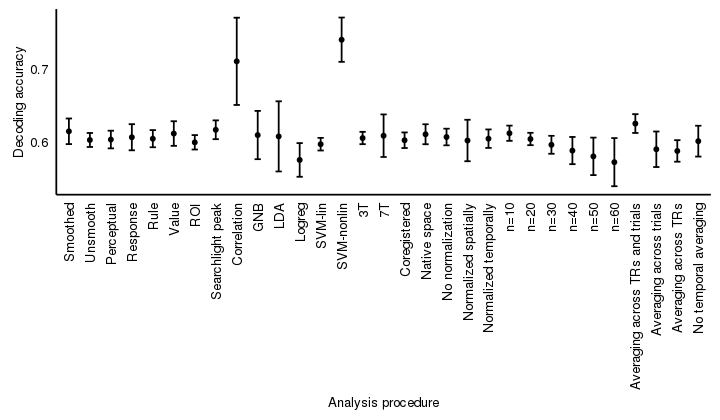

In [46]:

mainlinewidth=.5
textsize = 8
labelsize = 8

## Analysis Features 
p1 <-ggplot(aes(y = Accuracy, x = B,ymax = Accuracy + se, ymin=Accuracy - se), 
            data = dd_all) +
geom_point(size=1)+geom_errorbar(width=0.3)


p1<-p1+xlab('Analysis procedure')
p1<-p1+ylab('Decoding accuracy')
p1<-p1+theme(panel.background=element_blank())
p1<-p1+scale_x_discrete(labels=alabels)
p1<-p1+theme(axis.line.x = element_line(color="black", size = mainlinewidth),
        axis.line.y = element_line(color="black", size =mainlinewidth))
p1<-p1+theme(axis.ticks.x=element_blank(),axis.ticks.y=element_blank())
p1<-p1+theme(axis.line.x = element_line(color="black", size = mainlinewidth),
        axis.line.y = element_line(color="black", size =mainlinewidth))

p1<-p1+theme(axis.text.y = element_text(size=textsize,family='Helvetica',colour='black'))
p1<-p1+theme(axis.text.x = element_text(angle = 90, hjust = 1,size=textsize,vjust=0.5,
                                        family='Helvetica',colour='black'))
p1<-p1+theme(plot.title = element_text(size=labelsize,family='Helvetica',colour='black'))
p1<-p1+theme(axis.title.x = element_text(size=labelsize,family='Helvetica',colour='black'))
p1<-p1+theme(axis.title.y = element_text(size=labelsize,family='Helvetica',colour='black'))
p1<-p1+theme(axis.ticks.x=element_blank(),axis.ticks.y=element_blank())


setEPS()
postscript('../Figures/Supp_individual_regressions.eps',width=6,height=3.5)
p1
dev.off()

png('../Figures/Supp_individual_regressions.png',width=6,height=3.5,units="in",res=400)
#postscript('../Figures/Supp/full_regression_moreregions.eps',width=6,height=7)

p1
dev.off()

options(repr.plot.width=6, repr.plot.height=3.5)
p1

# Likelihood Ratio Tests 

In [71]:
null_model<-lme(Accuracy.50~1,random=~1|PID,data=d,method='ML')



In [69]:
model_info<-lme(as.formula('Accuracy.50~Info.type'),random=~1|PID,data=d,method='ML')
a<-anova(null_model,model_info)
dd<-data.frame(a)[c('Model','df','AIC','BIC','logLik','L.Ratio','p.value')]

model_rs<-lme(as.formula('Accuracy.50~Roi.Search'),random=~1|PID,data=d,method='ML')
a<-anova(null_model,model_rs)
d_new<-data.frame(a)[c('Model','df','AIC','BIC','logLik','L.Ratio','p.value')]
dd<-rbind(dd,d_new[2,])

model_pt<-lme(as.formula('Accuracy.50~Pattern.type'),random=~1|PID,data=d,method='ML')
a<-anova(null_model,model_pt)
d_new<-data.frame(a)[c('Model','df','AIC','BIC','logLik','L.Ratio','p.value')]
dd<-rbind(dd,d_new[2,])

model_ct<-lme(as.formula('Accuracy.50~Classifier.type'),random=~1|PID,data=d,method='ML')
a<-anova(null_model,model_ct)
d_new<-data.frame(a)[c('Model','df','AIC','BIC','logLik','L.Ratio','p.value')]
dd<-rbind(dd,d_new[2,])

model_sc<-lme(as.formula('Accuracy.50~Scanner'),random=~1|PID,data=d,method='ML')
a<-anova(null_model,model_sc)
d_new<-data.frame(a)[c('Model','df','AIC','BIC','logLik','L.Ratio','p.value')]
dd<-rbind(dd,d_new[2,])

model_sm<-lme(as.formula('Accuracy.50~Smoothing'),random=~1|PID,data=d,method='ML')
a<-anova(null_model,model_sm)
d_new<-data.frame(a)[c('Model','df','AIC','BIC','logLik','L.Ratio','p.value')]
dd<-rbind(dd,d_new[2,])

model_co<-lme(as.formula('Accuracy.50~Coregistration'),random=~1|PID,data=d,method='ML')
a<-anova(null_model,model_co)
d_new<-data.frame(a)[c('Model','df','AIC','BIC','logLik','L.Ratio','p.value')]
dd<-rbind(dd,d_new[2,])

model_patnorm<-lme(as.formula('Accuracy.50~Pattern.normalization.type'),random=~1|PID,data=d,method='ML')
a<-anova(null_model,model_patnorm)
d_new<-data.frame(a)[c('Model','df','AIC','BIC','logLik','L.Ratio','p.value')]
dd<-rbind(dd,d_new[2,])

model_n<-lme(as.formula('Accuracy.50~Num_subs'),random=~1|PID,data=d,method='ML')
a<-anova(null_model,model_n)
d_new<-data.frame(a)[c('Model','df','AIC','BIC','logLik','L.Ratio','p.value')]
dd<-rbind(dd,d_new[2,])


In [70]:
dd

,Model,df,AIC,BIC,logLik,L.Ratio,p.value
null_model,1,3,-1126.554,-1114.419,566.2772,NA,NA
model_info,2,6,-1120.771,-1096.501,566.3854,0.2163212,0.9749125
model_rs,2,4,-1125.87,-1109.69,566.9351,1.315841,0.2513398
model_pt,2,6,-1124.913,-1100.643,568.4567,4.358965,0.2252206
model_ct,2,8,-1140.431,-1108.071,578.2154,23.87634,0.0002293194
model_sc,2,4,-1124.568,-1108.388,566.2842,0.01406923,0.9055814
model_sm,2,4,-1124.911,-1108.731,566.4556,0.35678,0.5503
model_co,2,4,-1124.785,-1108.605,566.3923,0.2302904,0.6313086
model_patnorm,2,5,-1122.588,-1102.363,566.2942,0.03397916,0.9831539
model_n,2,4,-1125.66,-1109.48,566.83,1.105566,0.2930477


- classifier is strongly significant as indicated by the plot, but we wanted to be careful about that, because of the single observation in classifier and 4 with nonlinear svm.
- probbaly want to re-run without correlation. 
- pattern type is not significant at the llratio level (omnibust test), though it has a  marginally significant single coefficient comparison. It perhaps somewhat confirms what we suspect, but is also still noisy. 